In [2]:
from dlem.feature_extraction import extractor
import dlem.util as util
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
import cooler
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
def weighted_mse(input, target, weight=None):
    if weight is None:
        weight = torch.exp(target)
    return torch.mean(weight * (input - target) ** 2)

def wMSE_weight(weight_matrix):
    return weight_matrix

weights = wMSE_weight

locus = 'chr10:3000000-5000000' # 'chr10:20500000-22500000'
res = '10000'
lr = 0.5
num_epoch = 100
detach = {'10000':0.025,
          '5000':0.00125,
          '2000':0.005}

cell_line = 'H1hESC' 
cool_filename = '/Users/tina/LoopExtrusion/data/H1.mcool'
h5 = h5py.File(cool_filename, 'r')
cool = cooler.Cooler(h5['resolutions'][res])

model_name = 'minimal_dlem'

diag_start= 5 * int(10_000/int(res))
diag_stop= 120 * int(10_000/int(res))
depth = 10 * int(10_000/int(res))

res = int(res)
'''
depth above 10 (or 20) for 'chr10:3000000-5000000' significantly reduces the quality of the fit. it just spits out nonsense. 
--> it must have sth to do with the fact that also the starting diagonal is very very noisy. 
'''

patch_coarsegrain = adaptive_coarsegrain(cool.matrix(balance=True).fetch(locus), cool.matrix(balance=False).fetch(locus), cutoff=3, max_levels=8)
patch_coarsegrain_interpolated = interp_nan(patch_coarsegrain)               
patch = np.exp(util.diagonal_normalize(np.log( patch_coarsegrain_interpolated[np.newaxis]) ))

out = extractor(util.diagonal_normalize(np.log(patch))[0],
                                res=res,
                                learning_rate=lr,
                                arch=model_name,
                                diag_start=diag_start,
                                diag_stop=diag_stop,
                                depth=depth,
                                num_epoch = num_epoch,
                                loss=weighted_mse,  # you have to see where it's defined, because it's different. 
                                weights=weights(patch),
                                dev_name='cpu', do_plot=True)

params, corr = out
L, R = params




/Users/tina/miniforge3/envs/dlem_env/lib/python3.11/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur
/Users/tina/LoopExtrusion/loopextrusion-pytorch/dlem/util.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(dev)
/Users/tina/LoopExtrusion/loopextrusion-pytorch/dlem/util.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights).to(dev)


opt step 0
opt step 1
opt step 2
opt step 3
opt step 4
opt step 5
opt step 6
opt step 7
opt step 8
opt step 9
opt step 10
opt step 11
opt step 12
opt step 13
opt step 14
opt step 15
opt step 16
opt step 17
opt step 18
opt step 19
opt step 20
opt step 21
opt step 22
opt step 23
opt step 24
opt step 25
opt step 26
opt step 27
opt step 28
opt step 29
opt step 30
opt step 31
opt step 32
opt step 33
opt step 34


KeyboardInterrupt: 

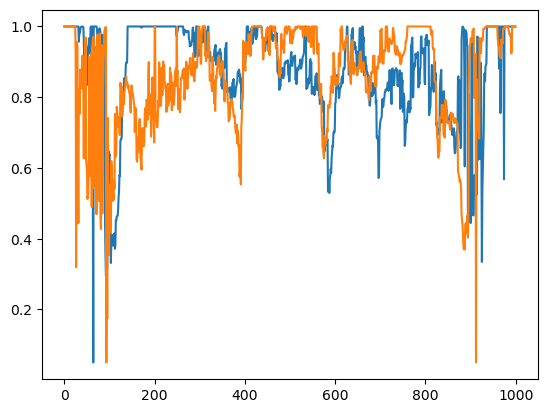

In [32]:
plt.plot(L)
plt.plot(R)

In [8]:
L, R = params